In [1]:
import os
import cv2
import numpy as np
import torch
from preprocess.utils import *
import matplotlib.pyplot as plt
from tqdm import tqdm

## Multiface mini-dataset 
Download the mini-dataset from https://github.com/facebookresearch/multiface (16.2 GB) 

In [2]:
# Dataset path
root = '/home/tungi/dataset/mface'
mesh_folder = os.path.join(root, 'm--20180227--0000--6795937--GHS/tracked_mesh/E061_Lips_Puffed/')
tex_folder = os.path.join(root, 'm--20180227--0000--6795937--GHS/unwrapped_uv_1024/E061_Lips_Puffed/average/')

In [3]:
# Create the rotation and translation matrices
R_source, T_source = look_at_view_transform(280, 0, 0)
R_target, T_target = look_at_view_transform(320, 0, 15)

In [4]:
# Collect the texture images
frame_numbers = []
for p in Path(tex_folder).glob('*.png'):
    n = os.path.split(str(p))[-1].split('.')[0]
    frame_numbers.append(n)
frame_numbers.sort()

In [46]:
# Create the mesh of each frame
resolution = 960
meshes = []
for n in tqdm(frame_numbers):
    obj, verts, tex = load_mf_obj(mesh_folder, tex_folder, n, tex_resolution=resolution)
    mesh = create_p3d_mesh(obj, verts, tex)
    meshes.append(mesh)

100%|███████████████████████████████████████████| 64/64 [00:05<00:00, 11.51it/s]


In [47]:
# Create the rotation and translation matrices
R_source, T_source = look_at_view_transform(280, 0, 0)
R_target, T_target = look_at_view_transform(280, 0, 9)

# Create the rgbd video frames
z_far = 800
nview_frames = []
gt_frames = []
mask_frames = []
sview_frames = []
depth_frames = []

for mesh in tqdm(meshes):
    # source view    
    rgbd_source = mesh2rgbd(mesh, R_source, T_source, resolution=resolution, zfar=z_far, return_cam=False)
    frame_to_save = normalize_image_value(rgbd_source[0][..., :3], convert_to='255')
    sview_frames.append(frame_to_save)
    # depth
    depth = rgbd_source[0][..., 3].copy()
    depth, d_mask = normalize_depth_value(depth, z_far=z_far, bg_val=-1, convert_to='01')
    depth = normalize_image_value(depth, convert_to='255')
    depth_frames.append(depth)
    # novel view with artifacts
    cloud = rgbd2cloud(rgbd_source, R_source, T_source, zfar=z_far)
    rgb_target = cloud2rgb(cloud, R_target, T_target, resolution=resolution)
    frame_to_save = normalize_image_value(rgb_target[0], convert_to='255')
    nview_frames.append(frame_to_save)
    # gt 
    rgbd_gt = mesh2rgbd(mesh, R_target, T_target, resolution=resolution, zfar=z_far, return_cam=False)
    rgb_gt = rgbd_gt[0][..., :3]
    frame_to_save = normalize_image_value(rgb_gt, convert_to='255')
    gt_frames.append(frame_to_save)
    # mask
    mask = np.isclose(rgb_target[0], rgb_gt, atol=0.1) # each channel could have different results
    mask = np.logical_or(mask[..., 2], np.logical_or(mask[..., 0], mask[..., 1])) 
    mask = mask.astype(np.uint8)
    mask = normalize_image_value(1 - mask, convert_to='255')
    mask_frames.append(mask)

100%|███████████████████████████████████████████| 64/64 [00:20<00:00,  3.15it/s]


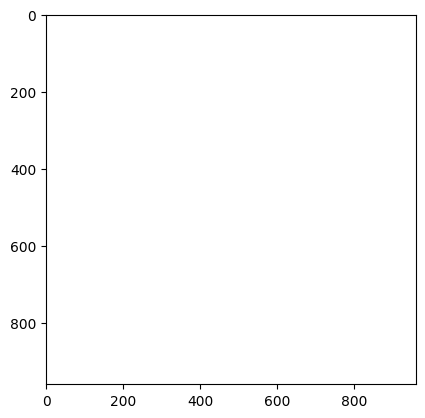

In [45]:
plt.imshow(rgb_target[0])

In [48]:
# Save videos
fps = 30
mkdir_if_missing('./preprocess/videos')

save_path = os.path.join('./preprocess/videos', 'input_video.mp4')
save_video(save_path, sview_frames, fps=fps, resolution=(resolution, resolution))
save_path = os.path.join('./preprocess/videos', 'input_depth.mp4')
save_video(save_path, depth_frames, fps=fps, resolution=(resolution, resolution))
save_path = os.path.join('./preprocess/videos', 'target_mask.mp4')
save_video(save_path, mask_frames, fps=fps, resolution=(resolution, resolution))
save_path = os.path.join('./preprocess/videos', 'target_video.mp4')
save_video(save_path, nview_frames, fps=fps, resolution=(resolution, resolution))
save_path = os.path.join('./preprocess/videos', 'target_gt.mp4')
save_video(save_path, gt_frames, fps=fps, resolution=(resolution, resolution))

## Visualize results

In [17]:
def read_frame_from_video(video_path, im_size=(240, 240), is_color=True):
    """
    Return:
        frames: list of np arrays
    """
    frames = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = frame if is_color else frame[:, :, 0]
        frame = cv2.resize(frame, im_size)
        frames.append(frame.astype(np.uint8)[..., ::-1])
    cap.release()
    return frames

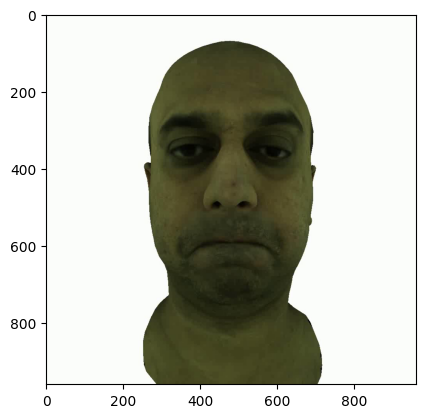

In [24]:
input_video = read_frame_from_video(os.path.join('./preprocess/videos', 'input_video.mp4'), im_size=(resolution, resolution))
plt.imshow(input_video[0])

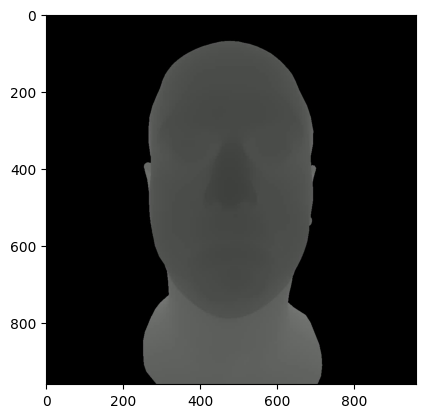

In [25]:
input_depth = read_frame_from_video(os.path.join('./preprocess/videos', 'input_depth.mp4'), im_size=(resolution, resolution))
plt.imshow(input_depth[0])

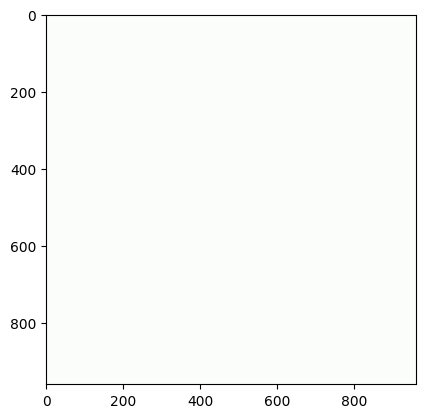

In [26]:
target_video = read_frame_from_video(os.path.join('./preprocess/videos', 'target_video.mp4'), im_size=(resolution, resolution))
plt.imshow(target_video[0])

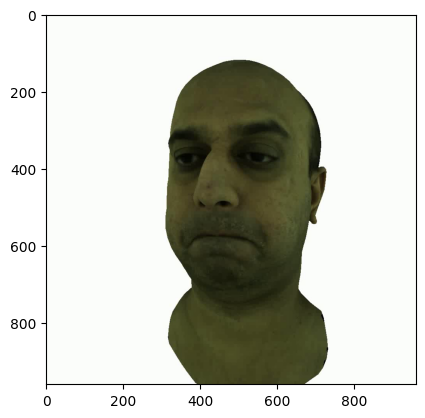

In [27]:
target_gt = read_frame_from_video(os.path.join('./preprocess/videos', 'target_gt.mp4'), im_size=(resolution, resolution))
plt.imshow(target_gt[0])

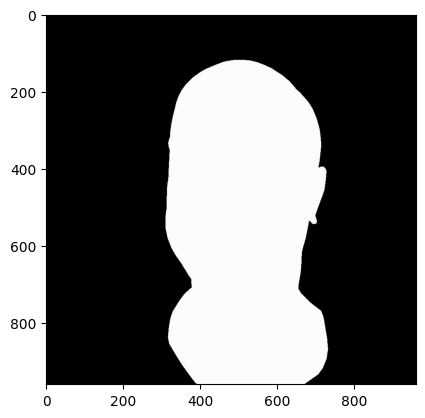

In [28]:
target_mask = read_frame_from_video(os.path.join('./preprocess/videos', 'target_mask.mp4'), im_size=(resolution, resolution))
plt.imshow(target_mask[0])